### Value at Risk (VaR) Analysis using the Parametric Method

Also known as the variance-covariance method. The parametric method estimates VaR by assuming that portfolio returns follow a normal distribution.

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
adj_close_df = pd.read_csv('data/stocks.csv', parse_dates=['Date'], index_col='Date')

In [3]:
tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']

In [4]:
log_returns_df = np.log(1 + adj_close_df.pct_change())
log_returns_df.dropna(inplace=True)

In [5]:
log_returns_df.head()

,SPY,BND,GLD,QQQ,VTI
Date,,,,,
2009-08-25,0.001941,0.001653,0.004538,0.002977,0.001921
2009-08-26,0.000097,0.000636,0.000323,-0.001735,-0.000768
2009-08-27,0.002227,-0.001144,0.004302,0.002478,0.003452
2009-08-28,-0.000194,0.002032,0.007270,0.000989,-0.000766
2009-08-31,-0.008939,0.001902,-0.005020,-0.010189,-0.009624


###  Equally Weighted Portfolio
Equally weighted portfolio with a total value of 1,000,000

In [6]:
portfolio_value = 1000000
weights = np.array([1/len(tickers)]*len(tickers))
print(weights)

[0.2 0.2 0.2 0.2 0.2]


In [7]:
historical_returns_df = (log_returns_df * weights).sum(axis=1)

print(historical_returns_df.head())

Date
2009-08-25    0.002606
2009-08-26   -0.000289
2009-08-27    0.002263
2009-08-28    0.001866
2009-08-31   -0.006374
dtype: float64


### X-Day Historical Returns

X-day historical returns. In this example, we’ll use a 50-day window.

In [8]:
days = 5
historical_x_day_returns = historical_returns_df.rolling(window=days).sum()
print(historical_x_day_returns)

Date
2009-08-25         NaN
2009-08-26         NaN
2009-08-27         NaN
2009-08-28         NaN
2009-08-31    0.000072
                ...   
2024-08-12    0.023410
2024-08-13    0.032413
2024-08-14    0.038092
2024-08-15    0.031666
2024-08-16    0.033728
Length: 3770, dtype: float64


In [9]:
# corr = log_returns_df.corr()
# corr.style.background_gradient(cmap='coolwarm').set_precision(2)

### Create Covariance Matrix and Calculate Portfolio Standard Deviation

In [10]:


cov_matrix = log_returns_df.cov() * 252
print(cov_matrix)


          SPY       BND       GLD       QQQ       VTI
SPY  0.029468 -0.000011  0.001648  0.032584  0.030086
BND -0.000011  0.002322  0.002230  0.000207  0.000035
GLD  0.001648  0.002230  0.024443  0.001902  0.001799
QQQ  0.032584  0.000207  0.001902  0.041807  0.033284
VTI  0.030086  0.000035  0.001799  0.033284  0.030964


### Calculating Portfolio Standard Deviation

Calculating portolfio variance and taking square root of variance

In [11]:
portfolio_std_dev = np.sqrt(weights.T @ cov_matrix @ weights)
portfolio_std_dev

0.11602286357061328

In [12]:
confidence_levels = [0.9, 0.95, 0.99]

### VaR at different confidence level

norm.ppf(cl) -> z-score of confidence level

In [13]:
VaRs = []

for cl in confidence_levels:
    var = portfolio_value * portfolio_std_dev * norm.ppf(cl) * np.sqrt(days/252)
    VaRs.append(var)

In [14]:
VaRs

[20944.229948893644, 26881.628114982333, 38019.19963659516]

In [15]:
print(f'{"Confidence Level":<20} {"Value at Risk":<20}')
print('-' * 40)

for cl, VaR in zip(confidence_levels, VaRs):
    print(f'{cl * 100:>6.0f}%: {"":<8} ${VaR:>10,.2f}')

Confidence Level     Value at Risk       
----------------------------------------
    90%:          $ 20,944.23
    95%:          $ 26,881.63
    99%:          $ 38,019.20


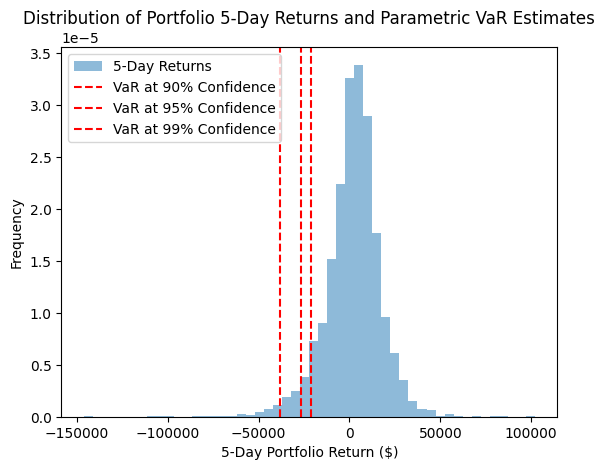

In [16]:
# Convert returns to dollar values for the histogram
historical_x_day_returns_portfolio = historical_x_day_returns * portfolio_value

# Plot the histogram
plt.hist(historical_x_day_returns_portfolio, bins=50, density=True, alpha=0.5, label=f'{days}-Day Returns')

# Add vertical lines representing VaR at each confidence level
for cl, VaR in zip(confidence_levels, VaRs):
    plt.axvline(x=-VaR, linestyle='--', color='r', label='VaR at {}% Confidence'.format(int(cl * 100)))

plt.xlabel(f'{days}-Day Portfolio Return ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio {days}-Day Returns and Parametric VaR Estimates')
plt.legend()
plt.show()